## Use MCMC to Approximate a Complicated Probability Didstribution

Based on the following video: https://www.youtube.com/watch?v=MxI78mpq_44

In [4]:
import numpy as np
from matplotlib import pyplot as plt

### The Probability Distribution we Want to Approximate

Let's assume we want to approximate the following complicated distribution:

$P(x)=\dfrac{(2+\sin(5x)+\sin(2x))e^{-x^2}}{\int_{-\infty} ^{\infty}(2+\sin(5x)+\sin(2x))e^{-x^2}}$

Doing the normalizing integral in the demoninator may be compliated or not possible so we can use MCMC to approximate this distribution. We can plot un-normalized distribution below to see what our target distribution looks like.

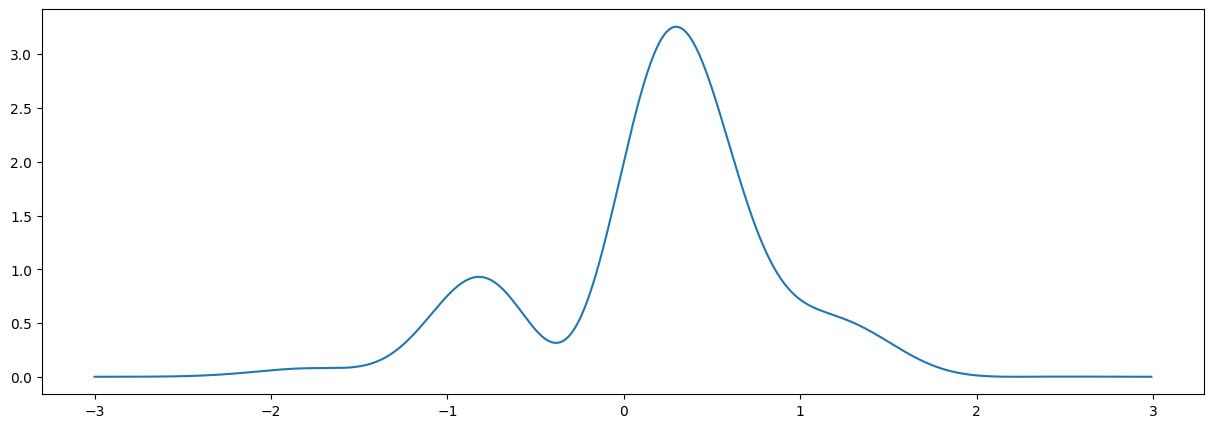

In [5]:
def TargetDist(x):
    dist_values = np.exp(-x**2) * (2 + np.sin(5*x) + np.sin(2*x))
    return dist_values

x_pts = np.arange(-3, 3, 0.01)
y_pts =TargetDist(x_pts)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(x_pts, y_pts, '-')
plt.show()

### The Method

We want to define a Markov chain so that the stationary distribution of this Markov Chain is $P(X)$. The stationary state is where the forward and reverse transition probabilities between adjacent states are equal. The Markov chain will generate a sequence of $n$ $x$ values so that as $n \to \infty$, we will have $x_n \approx P(x)$.

From a given state $x_n$ it is a 2 step process to generate $x_{n+1}$.

First we need to generate a candidate next state $x^*$ which is sampled from a distribution $Q(X^*|x_n)$ which depends on the current state of the Markov chain $x_n$. We need the distribution to be centred on $x_n$ so we can use a normal distribution to keep it simple but can also use more complicated distributions if we want.

Second, we need to see if we accept the generated candidate state as the next state in the Markov chain. We need to calculate an acceptance probability $A(x_n \to x^*)$ which is given by:

$A(x_n \to x^*) = min(a, \dfrac{P(x^*)}{P(x_n)}\times\dfrac{Q(x_n|x^*)}{Q(x^*|x_n)})$

The first term, ratio of probabilities is easy to compute because we know the probability distribution up to the normalizing constant which cancels in the ration anyways. Hence, we can just substitute $x_n$ and $x^*$ into the numerator of $P(x)$.

The second term is more complicated. $Q(x^*|x_n)$ is the probability of generating $x^*$ given the current state is $x_n$. Likewise, $Q(x_n|x^*)$ is the probability of generating $x_n$ given the current state is $x^*$. If the generating distribution is symmetric, like a normal distribution, these two  probabiliteis are equal and so this ratio becomes $1$. Using a normal distribution to generate your next point is known as the Metropolis algorithm. A more general case, the Metropolis-Hastings algoritms makes use of non-symmetric generating functions as well.

If the candidate point is accepted, we get $x_{n+1}=x^*$. Otherwise, $x_{n+1}=x_n$.

It often takes some number of itterations for the Markov chain to arrive at the steady state, these are not in the true $P(x)$ distribution and so there is often a burn-in number defined which is just the number of states you remove from the beginning of your chain so they don't impact the result.

In [6]:
def GetNextState(current_state, stdv):
    '''
    Returns the next point in the Markov Chain based
    on the Metropolis algorithm using a normal distribution
    with a specified standard deviation.
    '''
    candidate_state = np.random.normal(current_state, stdv)
    acceptance_prob = TargetDist(candidate_state) / TargetDist(current_state)
    random_number   = np.random.uniform()

    if random_number <= acceptance_prob:
        next_state = candidate_state
        accepted   = True
    else:
        next_state = current_state
        accepted   = True
    
    return next_state, accepted

### Running the Markov Chain Monte Carlo

In [79]:
initial_state = 1
num_samples   = 10000
standard_dev  = 1
burnin        = 100

states = np.zeros(num_samples - burnin)

current_state = initial_state

for i in np.arange(num_samples):
    next_state = GetNextState(current_state, standard_dev)[0]
    current_state = next_state
    if i <= burnin:
        continue
    states[i - burnin] = current_state

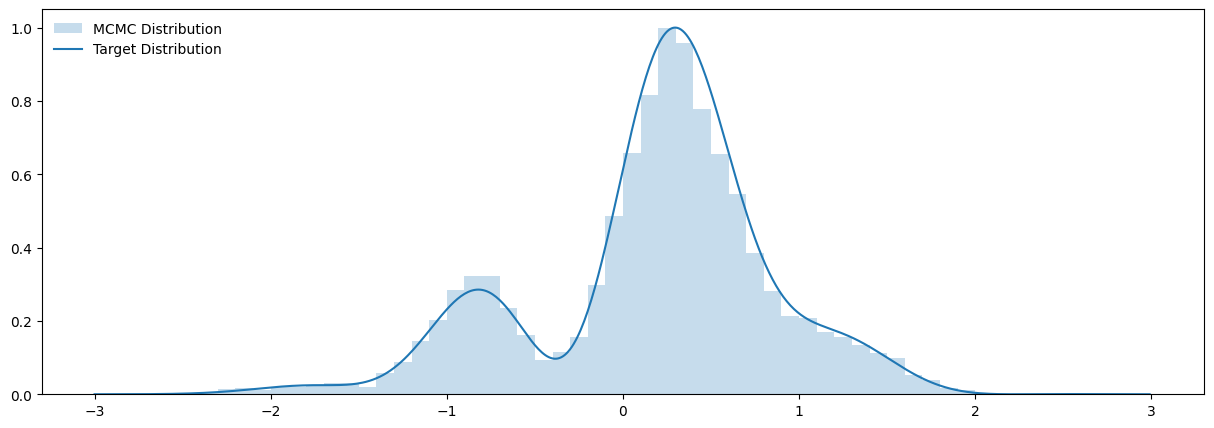

In [80]:
# Plot setup
# ---------------------------------------------------
bin_width = 0.1
bins      = np.arange(-3, 3 + bin_width, bin_width)

# Normalize mcmc probabilities to sum to 1
#mcmc_normalization = (1 / len(states)) * np.ones(len(states))

# Normalize mcmc distribution to peak at 1
mcmc_normalization = 1 / np.max(ax.hist(states, bins=bins)[0]) * np.ones(len(states))

'''
Plot mcmc simulation
'''
fig, ax = plt.subplots(figsize=(15, 5))

mcmc_dist = ax.hist(states, bins=bins, weights=mcmc_normalization, color='C0', alpha=0.25, label='MCMC Distribution')[0]
ax.plot(x_pts, y_pts / np.max(y_pts), '-', color='C0', label='Target Distribution')

plt.legend(fontsize=10, loc='upper left', frameon=False, framealpha=0)
plt.show()

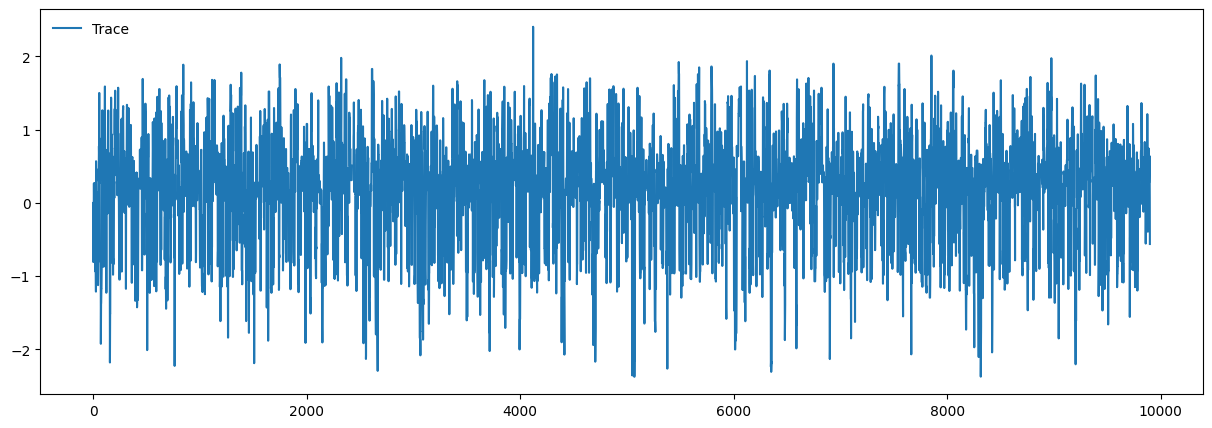

In [81]:
'''
Plot trace
'''
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(np.arange(len(states)), states, '-', color='C0', label='Trace')

plt.legend(fontsize=10, loc='upper left', frameon=False, framealpha=0)
plt.show()